In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import LMC
import archinfo
import imp
import astropy.stats
import scipy
import scipy.signal as sig
import scipy.optimize as op
from scipy.optimize import curve_fit
import dcor
import random
import collections

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric
from sklearn.linear_model import LinearRegression

from KDEpy import FFTKDE

'''
Define a few constants
'''

pi = np.pi
MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

AU = 1.496e11

REARTH = 6371e3
RNEPTUNE = 24622e3

robinseggblue = '#bfe2ff'    #define a few colors
royalpurple = '#9e00a3'
lavender = '#cc98d9'

NBOOT = 64

In [2]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [3]:
my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/oviraptor_master.csv'
raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[0]
VALUES = raw_data[1:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return np.array(arr)

In [4]:
# CONVERT STRINGS TO FLOATS
def is_number(s):
    '''
    checks if input string s is a number
    or if every entry in a list s is a number
    '''
    if type(s) != list:
        try:
            float(s)
            return True
        except ValueError:
            return False
    else:
        for part in s:
            status = True
            try:
                float(part)
                status = True
            except ValueError:
                status = False
        return status
    
def either_mass_or_radius(masses, radii):
    '''
    Every planet must have a measured mass or radius to be included in our study.
    Otherwise, we have nothing to work with.
    '''
    arr = []
    for i in range(len(masses)):
        if is_number(masses[i]) or is_number(radii[i]):
            arr.append(True)
        else:
            arr.append(False)
    return np.array(arr)
    

d = {}
d['starname'] = get_key('Starname')
d['rp'] = get_key('Rp')
d['mp'] = get_key('Mp')
d['ms'] = get_key('Ms')
#d['rs'] = get_key('Rs')
d['p'] = get_key('P')
d['disc_method'] = get_key('Detection Method')              #'disc_method' varies within a system
d['sys_disc_method'] = get_key('System Detection Method')   #'sys_disc_method' should be constant for every planet
                                                            #within a system

legitimate_entries = either_mass_or_radius(d['mp'], d['rp'])

print('Removed the following systems because they have exoplanets without both a mass and radius:')
for s in d['starname'][legitimate_entries == False]:
    print(s)

d['starname'] = d['starname'][legitimate_entries == True]           #all entries with True have either a measured
d['rp'] = d['rp'][legitimate_entries == True]                       #mass or radius
d['mp'] = d['mp'][legitimate_entries == True]
d['ms'] = d['ms'][legitimate_entries == True]
#d['rs'] = d['rs'][legitimate_entries == True]
d['p'] = d['p'][legitimate_entries == True]                         #We are simply removing planets without either
d['disc_method'] = d['disc_method'][legitimate_entries == True]     #a measured mass or radius
d['sys_disc_method'] = d['sys_disc_method'][legitimate_entries == True]

d0 = d.copy()

Removed the following systems because they have exoplanets without both a mass and radius:
HIP 41378
HIP 41378
HIP 41378
HIP 41378
HIP 41378
Kepler-37
Kepler-415
Kepler-416
Kepler-417


In [5]:
def mass_radius(mp): 
    '''
    mp - float 
    
    Uses the mass-radius relation given in Chen and Kipping (2017).  This method takes mass and 
    outputs radius.  mp is given in Earth masses, and rp is returned in Earth radii.  The specific numbers were obtained
    from here: https://exoplanetarchive.ipac.caltech.edu/docs/pscp_calc.html.
    '''
    mp = float(mp)
    if mp <= 2:                                          
        rp = 10**0.00346*mp**0.2790
    elif mp*MEARTH/MJUPITER <= 0.41:
        rp = 10**-0.0925*mp**0.589
    elif mp*MEARTH/MSUN <= 0.08:
        rp = 10**1.25*mp**-0.044
    else:
        rp = 10**-2.85*mp**0.881
    return rp

for i in range(len(d['mp'])):
    if d['rp'][i] == '' and is_number(d['mp'][i]) == True:        #implementing mass-radius relation 
        d['rp'][i] = mass_radius(d['mp'][i]) 
        
def radius_mass(rp):
    '''
    rp - float  
    
    Takes a radius measurement and outputs its corresponding mass using the mass-radius relation in Chen and Kipping
    (2017).  This is kind of like the inverse of mass_radius above.  The specific numbers were obtained from here: 
    https://exoplanetarchive.ipac.caltech.edu/docs/pscp_calc.html
    '''
    rp = float(rp)
    if rp < 1.23:
        mp = 10**((np.log10(rp)-0.00346)/0.2790)
    elif rp <= 11.1:
        mp = 10**((np.log10(rp)+0.0925)/0.589)
    else:
        mp = 0
    return mp

for i in range(len(d['rp'])):
    if d['mp'][i] == '' and is_number(d['rp'][i]) == True:             #implementing radius-mass relation
        d['mp'][i] = radius_mass(d['rp'][i])

In [6]:
def positivity_condition(masses):
    '''
    Since the radius-mass relation yields m=0 for r>11.1, we must eliminate systems that are within this range.
    Thus, we only need to check if m=0.  Later, we remove planets in which m=0.
    '''
    entries = []
    for i in range(len(masses)):
        if float(masses[i]) <= 0:
            entries.append(False)
        else:
            entries.append(True)
    return np.array(entries)

legitimate_entries = positivity_condition(d['mp'])

d['mp'] = d['mp'][legitimate_entries == True]
d['rp'] = d['rp'][legitimate_entries == True]
d['starname'] = d['starname'][legitimate_entries == True]
d['ms'] = d['ms'][legitimate_entries == True]
#d['rs'] = d['rs'][legitimate_entries == True]
d['p'] = d['p'][legitimate_entries == True]
d['disc_method'] = d['disc_method'][legitimate_entries == True]
d['sys_disc_method'] = d['sys_disc_method'][legitimate_entries == True]

In [7]:
# QUICKLY CLEAN DATA

d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

    
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0
    
    print('Removed the following systems because they had missing data:')
    for s in d['starname'][empty]:
        print(s)

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)
print('after removing missing data, number of objects =', len(d[KEY0]))

check_lengths(d)

def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew


# CONVERT STRINGS TO FLOATS (where applicable)
d = convert_floats(d)

total number of queried objects = 4088
Removed the following systems because they had missing data:
GJ 163
GJ 163
GJ 163
GJ 676 A
GJ 676 A
GJ 676 A
HAT-P-13
HAT-P-13
HAT-P-4
HD 41004 A
HD 47186
HD 62509
Kepler-108
Kepler-108
Kepler-155
Kepler-155
Kepler-1664
Kepler-1699
Kepler-191
Kepler-191
Kepler-257
Kepler-257
Kepler-257
Kepler-359
Kepler-359
Kepler-359
Kepler-383
Kepler-383
Kepler-400
Kepler-400
Kepler-449
Kepler-449
OGLE-TR-111
OGLE-TR-56
WASP-21
after removing missing data, number of objects = 4053


In [8]:
def legitimate_periods(periods, detection_method, max_period):
    '''
    This function is used to eliminate planets in RV systems with too long periods.
    This is meant for RV planets, so planets detected by any other methods are ignored.
    '''
    entries = []
    for i in range(len(periods)):
        if periods[i] <= max_period and detection_method == 'Radial Velocity':
            entries.append(True)
        elif detection_method == 'Transit' or detection_method == 'Mixed':
            entries.append(True)
        else:
            entries.append(False)
    return np.array(entries)

def legitimate_radii(radii, detection_method, min_radius):
    '''
    This function is used to eliminate planets in transit systems with too high radii.
    This is meant for transit planets, so planets detected by any other methods are ignored.
    '''
    entries = []
    for i in range(len(radii)):
        if radii[i] >= min_radius and detection_method == 'Transit':
            entries.append(True)
        elif detection_method == 'Radial Velocity' or detection_method == 'Mixed':
            entries.append(True)
        else:
            entries.append(False)
    return np.array(entries)

uniquesys = np.unique(d['starname'])
systems   = []

max_period = 1460                                                       #length of time used to create DR25 catalogue
min_radius = min(d['rp'][d['sys_disc_method'] == 'Radial Velocity'])    #minimum radius of an RV planet

for us in uniquesys:
    s = System()
    
    s.sysid = us
    s.starname = d['starname'][d['starname']==us][0]
    s.Mstar = d['ms'][d['starname']==us][0]
    #s.Rstar = d['rs'][d['starname']==us][0]
    
    s.masses = d['mp'][d['starname']==us]
    s.radii = d['rp'][d['starname']==us]
    s.detection_method = d['sys_disc_method'][d['starname']==us][0]
    s.periods = d['p'][d['starname']==us]
    
    '''
    Implementing first period, then radius conditions
    '''
    
    legitimate_entries = legitimate_periods(s.periods, s.detection_method, max_period)
    s.masses = s.masses[legitimate_entries == True]
    s.radii = s.radii[legitimate_entries == True]
    s.periods = s.periods[legitimate_entries == True]
    
    legitimate_entries = legitimate_radii(s.radii, s.detection_method, min_radius)
    s.masses = s.masses[legitimate_entries == True]
    s.radii = s.radii[legitimate_entries == True]
    s.periods = s.periods[legitimate_entries == True]
    
    '''
    Eliminating planets where r=0
    '''
    
    s.masses = s.masses[s.radii != 0]
    s.periods = s.periods[s.radii != 0]
    s.radii = s.radii[s.radii != 0]
    
    '''
    Eliminating planets that have masses less than 13 Jupiter masses
    '''
    
    s.periods = s.periods[s.masses*MEARTH/MJUPITER < 13]
    s.radii = s.radii[s.masses*MEARTH/MJUPITER < 13]
    s.masses = s.masses[s.masses*MEARTH/MJUPITER < 13]
    
    if len(s.masses) >= 3:
        
        '''
        We are only considering 3+ planet systems
        '''
    
        order = np.argsort(s.periods)

        s.masses = s.masses[order]     
        s.radii = s.radii[order]
        s.periods = s.periods[order]

        s.N = len(s.masses)
        s.Q = archinfo.Q(s.masses)
        s.mu = archinfo.mu(s.masses, s.Mstar)
        s.logmu = np.log10(s.mu)
        s.M = archinfo.M(s.periods, s.masses)
        s.S = archinfo.S(s.periods, s.masses, s.Mstar)
        s.C = archinfo.C(s.periods)

        systems.append(s)
        
logmu = np.zeros(len(systems))
detection_methods = []
starnames = []
for i, s in enumerate(systems):
    logmu[i] = s.logmu
    detection_methods.append(s.detection_method)
    starnames.append(s.starname)
detection_methods = np.array(detection_methods)

min_logmu = min(logmu[detection_methods == 'Radial Velocity'])
max_logmu = -2.0 

sv_systems = []

for i, s in enumerate(systems):
    if s.logmu > max_logmu:
        print(s.starname + ' <- above the maximum logmu, %.3f' %max_logmu)
    if s.logmu < min_logmu:
        print(s.starname + ' <- below the minimum logmu, %.3f' %min_logmu)
    if s.logmu <= max_logmu and s.logmu >= min_logmu:
        sv_systems.append(s)
systems = sv_systems

K2-219 <- below the minimum logmu, -4.444
K2-239 <- below the minimum logmu, -4.444
Kepler-1254 <- below the minimum logmu, -4.444
Kepler-126 <- below the minimum logmu, -4.444
Kepler-132 <- below the minimum logmu, -4.444
Kepler-157 <- below the minimum logmu, -4.444
Kepler-197 <- below the minimum logmu, -4.444
Kepler-206 <- below the minimum logmu, -4.444
Kepler-208 <- below the minimum logmu, -4.444
Kepler-217 <- below the minimum logmu, -4.444
Kepler-220 <- below the minimum logmu, -4.444
Kepler-226 <- below the minimum logmu, -4.444
Kepler-286 <- below the minimum logmu, -4.444
Kepler-295 <- below the minimum logmu, -4.444
Kepler-301 <- below the minimum logmu, -4.444
Kepler-326 <- below the minimum logmu, -4.444
Kepler-327 <- below the minimum logmu, -4.444
Kepler-332 <- below the minimum logmu, -4.444
Kepler-334 <- below the minimum logmu, -4.444
Kepler-336 <- below the minimum logmu, -4.444
Kepler-339 <- below the minimum logmu, -4.444
Kepler-354 <- below the minimum logmu, -4

In [9]:
Nsys = len(systems)

N  = np.zeros(Nsys)
mu = np.zeros(Nsys)
Q  = np.zeros(Nsys)
M  = np.zeros(Nsys)
S  = np.zeros(Nsys)
C  = np.zeros(Nsys)
Mstar = np.zeros(Nsys)
#Rstar = np.zeros(Nsys)
logmu_over_N = np.zeros(Nsys)
detection_methods = ['']*Nsys
periods = [[0]]*Nsys
masses = [[0]]*Nsys
radii = [[0]]*Nsys
starnames = ['']*Nsys

for i, s in enumerate(systems):
    N[i]  = s.N
    mu[i] = s.mu
    Q[i]  = s.Q
    M[i]  = s.M
    S[i]  = s.S
    C[i]  = s.C
    Mstar[i] = s.Mstar
    #Rstar[i] = s.Rstar
    logmu_over_N[i] = np.log10(s.mu/s.N)
    detection_methods[i] = s.detection_method
    periods[i] = s.periods
    masses[i] = s.masses
    radii[i] = s.radii
    starnames[i] = s.starname

logmu = np.log10(mu)
detection_methods = np.array(detection_methods)
starnames = np.array(starnames)

55 Cnc 0.0011740212658713847 [ 1.91   13.913   8.5136  7.5887]
61 Vir 0.00014761718826933876 [2.1098 4.4635 5.1102]
DMPP-1 0.00010263912723768251 [1.6472 1.8633 3.0623 5.2881]
GJ 1061 0.00011888721962889568 [1.1005 1.1764 1.1571]
GJ 180 0.00014283928370590452 [2.4317 2.4117 2.6604]
GJ 3138 7.270155919845038e-05 [1.1839 1.8766 3.2283]
GJ 3293 0.00039695816911879697 [1.6268 5.1939 2.6686 4.8683]
GJ 581 0.0002228378446015294 [1.1688 4.1068 2.2058]
GJ 876 0.009119633067987071 [ 2.5059 14.006  13.31    3.9201]
HD 10180 0.00027494047780892106 [3.6977 3.4949 5.4551 5.1164 5.1581]
HD 136352 8.969611985412821e-05 [2.0383 3.2823 2.8663]
HD 141399 0.002641632046474396 [14.292 13.628 13.7  ]
HD 158259 7.077613425860573e-05 [1.2927 2.2293 2.1845 2.34   2.3535]
HD 160691 0.001972015767265244 [ 3.2382 14.201  13.49  ]
HD 164922 0.00042952801930439726 [ 1.8285  3.6611 13.288 ]
HD 20781 0.00013687226368102635 [1.2109 2.1654 3.2482 3.8292]
HD 20794 6.294407862697983e-05 [1.4506 1.3534 2.0358 2.0283]
HD 

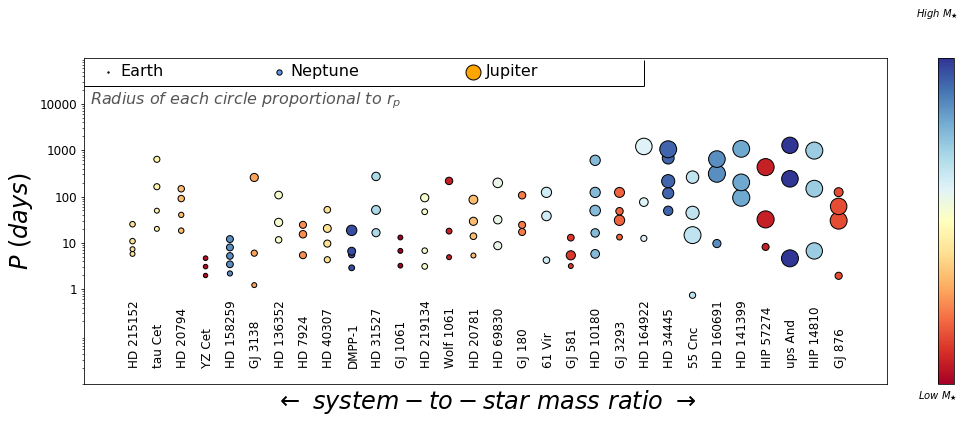

In [10]:
'''
Make gallery of RV systems of 3+ exoplanets 
'''

mu_rv = []
masses_rv = []
periods_rv = []
radii_rv = []
Mstar_rv = []
starnames_rv = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Radial Velocity' and len(periods[i]) > 2:
        mu_rv.append(mu[i])
        periods_rv.append(periods[i])
        masses_rv.append(masses[i])
        radii_rv.append(radii[i])
        Mstar_rv.append(Mstar[i])
        starnames_rv.append(starnames[i])
        print(starnames[i] + " " + str(mu[i]) + " " + str(radii[i]))

mu_rank = np.array(stats.rankdata(mu_rv), dtype = 'int')
mu_pos = []
for i in range(len(masses_rv)):
    for j in range(len(masses_rv[i])):
        mu_pos.append(mu_rank[i])

cm = plt.cm.get_cmap('RdYlBu')


ms_final = []
for i in range(len(masses_rv)):
    arr = []
    for j in range(len(masses_rv[i])):
        arr.append(Mstar_rv[i])
    ms_final.append(arr)
    

ms_rank = np.array(stats.rankdata([item for sublist in ms_final for item in sublist])-1, dtype = 'int')

plt.figure(figsize = (18, 6))
plt.tight_layout()

plt.scatter(mu_pos, [item for sublist in periods_rv for item in sublist], c = ms_rank, cmap = cm, \
s = 225*REARTH/RJUPITER*np.array([item for sublist in radii_rv for item in sublist]), edgecolors = 'black')
cbar = plt.colorbar()
plt.clim(min(ms_rank), max(ms_rank))
cbar.set_ticks([])

for i in range(len(radii_rv)):
    plt.text(mu_rank[i]-0.2, 0.02, starnames_rv[i], rotation = 90, va = 'bottom', fontsize = 12)

plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.ylabel(r'$P\ (days)$', fontsize=24)

plt.xlim(-1, max(mu_pos)+2)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize = 12)

cbar.ax.text(1, -5, r"$Low\ M_{\bigstar}$", va = 'bottom', ha = 'center')
cbar.ax.text(1, 120, r"$High\ M_{\bigstar}$", va = 'top', ha = 'center')

plt.ylim(0.009, 100000)

plt.hlines(25000, -1, 22, lw = 1)
plt.vlines(22, 25000, 90000, lw = 1)
plt.plot(0, 50000, 'o', markersize=15*REARTH/RJUPITER, color='lightgrey', mec='k', mew=1)
plt.text(0.5, 50000, 'Earth', va='center', fontsize=16)
plt.plot(7, 50000, 'o', markersize=15*RNEPTUNE/RJUPITER, color='cornflowerblue', mec='k', mew=1)
plt.text(7.5, 50000, 'Neptune', va='center', fontsize=16)
plt.plot(15, 50000, 'o', markersize=15*RJUPITER/RJUPITER, color='orange', mec='k', mew=1)
plt.text(15.5, 50000, 'Jupiter', va='center', fontsize=16)

plt.text(-0.75,20000, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p$', \
         fontsize=16, color='#555555', va='top')

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/gallery.pdf', bbox_inches='tight')
plt.show()

GJ 357 0.00010017444487368498 [1.217  1.6616 2.3445]
HD 3167 6.065150272188842e-05 [1.7   2.521 2.86 ]
KOI-142 0.0036064261734530365 [ 3.438 14.042 13.142]
Kepler-122 0.00023240614551109904 [2.34 5.87 2.2  2.6  1.75]
Kepler-160 0.0003454109229732625 [ 1.715  3.76  12.175]
Kepler-19 0.0001468361449451624 [2.28 2.28 2.28]
Kepler-20 0.00017603909080776432 [1.868  0.865  3.047  1.003  4.7129 2.744 ]
Kepler-25 0.0002761344533495878 [ 2.748  5.217 10.025]
Kepler-338 6.996863224165233e-05 [1.56 2.44 2.34 3.  ]
Kepler-37 0.00010679196057960227 [0.336 0.75  1.94 ]
Kepler-411 0.00026927631596526647 [2.401  4.421  3.2823 3.319 ]
Kepler-46 0.007047987196135075 [ 1.64   9.057 13.522]
Kepler-48 0.002330090071004221 [ 1.88   2.71   2.04  13.366]
Kepler-56 0.004450550695859246 [ 6.51   9.8   12.792]
Kepler-65 0.0006521122731345373 [ 1.42   2.58   1.52  13.923]
Kepler-68 0.0007108272274836361 [ 2.679   1.2299 13.96  ]
Kepler-82 0.00018537309476145754 [1.77   2.47   4.07   5.34   4.8424]
WASP-47 0.00225

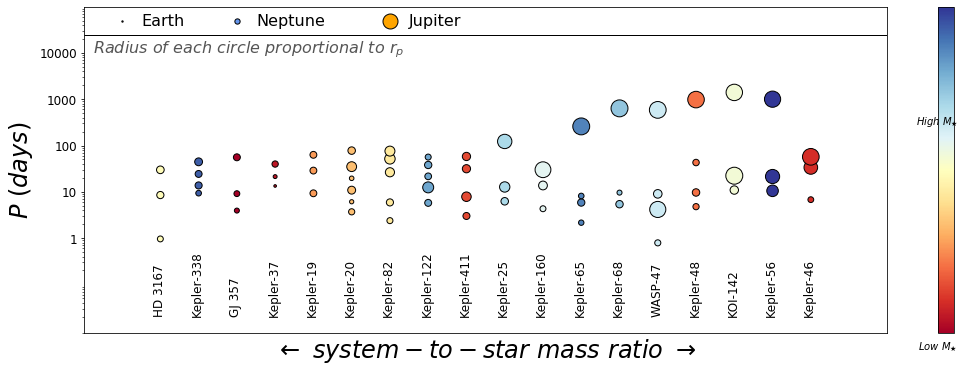

In [11]:
'''
Make gallery of mixed systems of 3+ exoplanets
'''

mu_mixed = []
masses_mixed = []
periods_mixed = []
radii_mixed = []
Mstar_mixed = []
starnames_mixed = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Mixed' and len(periods[i]) > 2:
        mu_mixed.append(mu[i])
        periods_mixed.append(periods[i])
        masses_mixed.append(masses[i])
        radii_mixed.append(radii[i])
        Mstar_mixed.append(Mstar[i])
        starnames_mixed.append(starnames[i])
        print(starnames[i] + " " + str(mu[i]) + " " + str(radii[i]))
        
mu_rank = np.array(stats.rankdata(mu_mixed), dtype = 'int')
mu_pos = []
for i in range(len(masses_mixed)):
    for j in range(len(masses_mixed[i])):
        mu_pos.append(mu_rank[i])

cm = plt.cm.get_cmap('RdYlBu')

ms_final = []
for i in range(len(masses_mixed)):
    arr = []
    for j in range(len(masses_mixed[i])):
        arr.append(Mstar_mixed[i])
    ms_final.append(arr)
    
ms_rank = np.array(stats.rankdata([item for sublist in ms_final for item in sublist])-1, dtype = 'int')

plt.figure(figsize = (18, 6))
plt.tight_layout()

plt.scatter(mu_pos, [item for sublist in periods_mixed for item in sublist], c = ms_rank, cmap = cm, \
s = 225*REARTH/RJUPITER*np.array([item for sublist in radii_mixed for item in sublist]), edgecolors = 'black')
cbar = plt.colorbar()
plt.clim(min(ms_rank), max(ms_rank))
cbar.set_ticks([])

for i in range(len(radii_mixed)):
    plt.text(mu_rank[i]-0.2, 0.02, starnames_mixed[i], rotation = 90, va = 'bottom', fontsize = 12)

plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.ylabel(r'$P\ (days)$', fontsize=24)

plt.xlim(-1, max(mu_pos)+2)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize = 12)

cbar.ax.text(1, -3, r"$Low\ M_{\bigstar}$", va = 'bottom', ha = 'center')
cbar.ax.text(1, 43, r"$High\ M_{\bigstar}$", va = 'top', ha = 'center')

plt.ylim(0.009, 100000)

plt.hlines(25000, -1, 22, lw = 1)
plt.vlines(22, 25000, 90000, lw = 1)
plt.plot(0, 50000, 'o', markersize=15*REARTH/RJUPITER, color='lightgrey', mec='k', mew=1)
plt.text(0.5, 50000, 'Earth', va='center', fontsize=16)
plt.plot(3, 50000, 'o', markersize=15*RNEPTUNE/RJUPITER, color='cornflowerblue', mec='k', mew=1)
plt.text(3.5, 50000, 'Neptune', va='center', fontsize=16)
plt.plot(7, 50000, 'o', markersize=15*RJUPITER/RJUPITER, color='orange', mec='k', mew=1)
plt.text(7.5, 50000, 'Jupiter', va='center', fontsize=16)

plt.text(-0.75,20000, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p$', \
         fontsize=16, color='#555555', va='top')

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/gallery_mixed.pdf', bbox_inches='tight')
plt.show()

EPIC 249893012 9.611093123683356e-05 [1.95 3.67 3.94]
GJ 9827 4.820317709060453e-05 [1.577 1.241 2.022]
HD 191939 0.00010516889645115348 [3.42 3.23 3.16]
HR 858 3.84993395611998e-05 [2.085 1.939 2.164]
K2-133 9.055023143146604e-05 [1.34  1.603 2.003 1.73 ]
K2-136 5.048456700345161e-05 [0.99 2.91 1.45]
K2-138 0.00011845710138642022 [1.57 2.52 2.66 3.29 2.81]
K2-148 4.295297706612973e-05 [1.33 1.73 1.64]
K2-155 7.131682808605386e-05 [1.8 2.6 1.9]
K2-16 5.740368946823498e-05 [1.03 2.02 2.54]
K2-165 4.595824777222931e-05 [1.274 1.554 2.648]
K2-183 7.800307611215078e-05 [2.599 2.87  2.86 ]
K2-187 6.91808462419161e-05 [1.3  1.8  3.17 2.38]
K2-19 0.00022258520131032014 [1.14 7.74 4.86]
K2-198 9.563011950643433e-05 [1.423 2.438 4.189]
K2-233 4.6336381227462736e-05 [1.398 1.335 2.64 ]
K2-266 0.00015003325533983501 [3.3  2.93 2.73]
K2-285 0.00015400908258432367 [2.59 3.53 2.48 1.95]
K2-3 5.716598097524164e-05 [2.4295 1.265  1.482 ]
K2-32 0.00014477645081441374 [1.01 4.96 2.74 3.27]
K2-37 6.38021

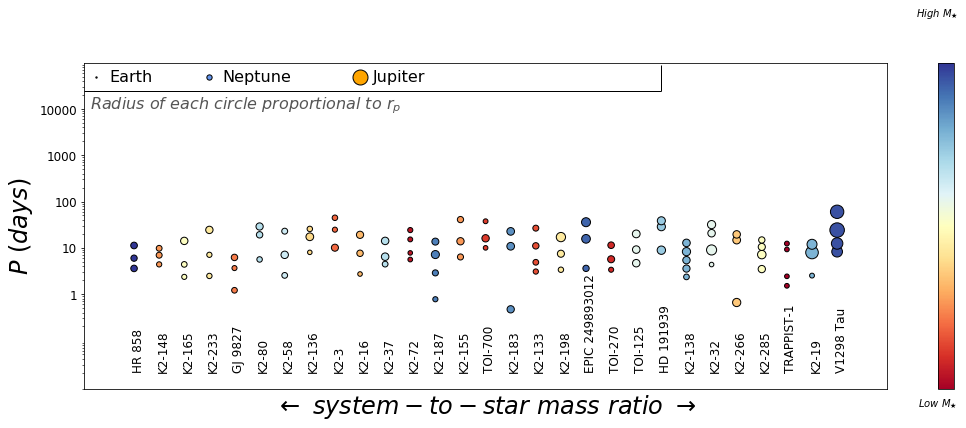

['K2-133' 'K2-72' 'TOI-270' 'TOI-700' 'TRAPPIST-1']


In [14]:
'''
Make gallery of non-Kepler transit systems of 3+ exoplanets
'''

mu_transit = []
masses_transit = []
periods_transit = []
radii_transit = []
Mstar_transit = []
starnames_transit = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Transit' and len(periods[i]) > 2 and 'Kepler' not in starnames[i] \
        and 'KOI' not in starnames[i]:
        mu_transit.append(mu[i])
        periods_transit.append(periods[i])
        masses_transit.append(masses[i])
        radii_transit.append(radii[i])
        Mstar_transit.append(Mstar[i])
        starnames_transit.append(starnames[i])
        print(starnames[i] + " " + str(mu[i]) + " " + str(radii[i]))
        
mu_rank = np.array(stats.rankdata(mu_transit), dtype = 'int')
mu_pos = []
for i in range(len(masses_transit)):
    for j in range(len(masses_transit[i])):
        mu_pos.append(mu_rank[i])

cm = plt.cm.get_cmap('RdYlBu')

ms_final = []
for i in range(len(masses_transit)):
    arr = []
    for j in range(len(masses_transit[i])):
        arr.append(Mstar_transit[i])
    ms_final.append(arr)
    
ms_rank = np.array(stats.rankdata([item for sublist in ms_final for item in sublist])-1, dtype = 'int')

plt.figure(figsize = (18, 6))
plt.tight_layout()

plt.scatter(mu_pos, [item for sublist in periods_transit for item in sublist], c = ms_rank, cmap = cm, \
s = 225*REARTH/RJUPITER*np.array([item for sublist in radii_transit for item in sublist]), edgecolors = 'black')
cbar = plt.colorbar()
plt.clim(min(ms_rank), max(ms_rank))
cbar.set_ticks([])

for i in range(len(radii_transit)):
    plt.text(mu_rank[i]-0.1, 0.02, starnames_transit[i], rotation = 90, va = 'bottom', fontsize = 12)

plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.ylabel(r'$P\ (days)$', fontsize=24)

plt.xlim(-1, max(mu_pos)+2)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize = 12)

cbar.ax.text(1, -5, r"$Low\ M_{\bigstar}$", va = 'bottom', ha = 'center')
cbar.ax.text(1, 110, r"$High\ M_{\bigstar}$", va = 'top', ha = 'center')

plt.ylim(0.009, 100000)

plt.hlines(25000, -1, 22, lw = 1)
plt.vlines(22, 25000, 90000, lw = 1)
plt.plot(-0.5, 50000, 'o', markersize=15*REARTH/RJUPITER, color='lightgrey', mec='k', mew=1)
plt.text(0, 50000, 'Earth', va='center', fontsize=16)
plt.plot(4, 50000, 'o', markersize=15*RNEPTUNE/RJUPITER, color='cornflowerblue', mec='k', mew=1)
plt.text(4.5, 50000, 'Neptune', va='center', fontsize=16)
plt.plot(10, 50000, 'o', markersize=15*RJUPITER/RJUPITER, color='orange', mec='k', mew=1)
plt.text(10.5, 50000, 'Jupiter', va='center', fontsize=16)

plt.text(-0.75,20000, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p$', \
         fontsize=16, color='#555555', va='top')

plt.savefig('C:/Users/djhoo/Documents/maiasaurus-master/Devin_Figures/gallery_transit.pdf', bbox_inches='tight')
plt.show()

starnames_transit, Mstar_transit = np.array(starnames_transit), np.array(Mstar_transit)
print(starnames_transit[Mstar_transit < 0.6])